<a href="https://colab.research.google.com/github/kayserim/prj_id/blob/main/generate_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")
%cd '/content/drive/MyDrive/cse6250_proj' 

Mounted at /content/drive
/content/drive/MyDrive/cse6250_proj


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from collections import defaultdict
import dask
import dask.dataframe as dd

HOURS_IN_A_DAY = 24

path = './data/all/'
#path = './data/demo/'

class DateRange:
    def __init__(self, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date

    def __contains__(self, check_date):
        return self.start_date <= check_date <= self.end_date

def remove_less_than_18yrs_old(icu_stays):
  #Note: although paper does not clarify filtering 18 yrs old according to intime in icu
  return icu_stays[( (icu_stays['DOB'] + timedelta(hours=18*365.25*HOURS_IN_A_DAY) ) < icu_stays['INTIME'])] 

def remove_icu_deaths(icu_stays):
  #Note: assuming dod_hosp is sufficient to check for icu deaths
  death_in_icu_mask = icu_stays['DOD_HOSP'].notna() & (icu_stays['INTIME']<icu_stays['DOD_HOSP']) & (icu_stays['DOD_HOSP']<icu_stays['OUTTIME']) 
  return icu_stays[~death_in_icu_mask] 

def check_case1(hadmid, icuid, multiple_icus_df):
  if hadmid not in multiple_icus_df.HADM_ID.values:
    return 0

  icu_stays = multiple_icus_df.loc[multiple_icus_df.HADM_ID ==hadmid][['ICU_STAYS']].iloc[0][0]
  if (icu_stays.index(icuid)+1)==len(icu_stays):# no need to check icuid existence only check if it is the last element or not
    return 0
  
  return 1

def date_ranges_intersect(range1, range2):
  intersection_start = max(range1.start_date, range2.start_date)
  intersection_end = min(range1.end_date, range2.end_date)
  return True if intersection_end >= intersection_start else False

def date_ranges_intersect_and_second_follows_first(range1, range2):
  if range1.start_date > range2.start_date:
    return False
  if range1.end_date < range2.start_date:
    return False
  return True

In [3]:
file = 'PATIENTS.csv'
patients = pd.read_csv(path+file)
patients['DOB'] = pd.to_datetime(patients['DOB'])
patients['DOD'] = pd.to_datetime(patients['DOD'])
patients['DOD_HOSP'] = pd.to_datetime(patients['DOD_HOSP'])
patients['DOD_SSN'] = pd.to_datetime(patients['DOD_SSN'])
#TODO is mimic-iii clean, do we need preprocessing like if expiry=1 then at least 1 dod should be set, and dob should always be set etc...
#patients.info() #46520 patients


In [7]:
file = 'ADMISSIONS.csv'
admissions = pd.read_csv(path+file)
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
admissions.dropna(subset=['DISCHTIME'], inplace=True)
hospital_deaths = admissions.loc[admissions.HOSPITAL_EXPIRE_FLAG==1][['HADM_ID']]
admissions_with_discharge = admissions.loc[~(admissions.HOSPITAL_EXPIRE_FLAG==1)][['HADM_ID']]

In [4]:
file = 'ICUSTAYS.csv'
icu_stays = pd.read_csv(path+file)
icu_stays['INTIME'] = pd.to_datetime(icu_stays['INTIME'])
icu_stays['OUTTIME'] = pd.to_datetime(icu_stays['OUTTIME'])
icu_stays = icu_stays.merge(patients, on='SUBJECT_ID', how='inner')
#icu_stays.info() #61532 icu stays
#icu_stays['SUBJECT_ID'].nunique() #46476 patients

#alhtough this is not mentioned in the paper, it makes sense to clean out cases still in icu
icu_stays.dropna(subset=['OUTTIME'], inplace=True)

icu_stays = remove_less_than_18yrs_old(icu_stays)
#icu_stays.info() #53329 icu stays
#icu_stays['SUBJECT_ID'].nunique() #38510 patients

icu_stays = remove_icu_deaths(icu_stays)
#icu_stays.info() #49128 icu stays --> #INCONSISTENCY paper have 48393
#icu_stays['SUBJECT_ID'].nunique() #35602 patients --> #INCONSISTENCY paper have 35334


In [5]:
# case1: transferred to ward but later was re-admitted to ICU, expected 3555
icu_stays_sorted = icu_stays.sort_values(by='INTIME')
icu_stays_per_hadm = icu_stays_sorted.groupby('HADM_ID')['ICUSTAY_ID'].apply(list).reset_index(name='ICU_STAYS')
case1_candidates = icu_stays_per_hadm[icu_stays_per_hadm['ICU_STAYS'].map(len)>1]
icu_stays['CASE1'] = icu_stays.apply(lambda row: check_case1(row.HADM_ID, row.ICUSTAY_ID, case1_candidates), axis=1)
#icu_stays['CASE1'].value_counts() # 3187 1s #INCONSISTENCY paper have 3555 1s

In [8]:
# case2: tranferred to ward and died later, expected 1974
last_icu_stay_of_admission = icu_stays_sorted.groupby('HADM_ID').last().reset_index() 
ward_deaths = last_icu_stay_of_admission.merge(hospital_deaths, on='HADM_ID', how='inner')[['HADM_ID','ICUSTAY_ID']] #we know this list does not contain ICUs with deaths so any inner join would mean deaths in ward
ward_deaths['CASE2'] = 1
icu_stays.drop(columns='CASE2', errors='ignore', inplace=True)#to prevent issues with multiple run of cell 
icu_stays = icu_stays.merge(ward_deaths[['CASE2', 'ICUSTAY_ID']], on='ICUSTAY_ID', how='left')
icu_stays['CASE2'] = icu_stays[['CASE2']].fillna(0) 
#icu_stays['CASE2'].value_counts()  # 2009 1s #INCONSISTENCY paper have 1974 1s

In [9]:
# case3: discharged but returned to icu within 30 days, expected 3205
first_icu_stay_of_admission = icu_stays_sorted.groupby('HADM_ID').first().reset_index() 
first_icu_stay_of_admission['STAY_RANGE'] = first_icu_stay_of_admission.apply(lambda row: DateRange(row['INTIME'], row['OUTTIME']), axis=1)
per_patient_first_icu_stays = first_icu_stay_of_admission.groupby('SUBJECT_ID')['STAY_RANGE'].apply(list).reset_index(name='STAY_RANGES')
per_patient_first_icu_stays = per_patient_first_icu_stays[per_patient_first_icu_stays['STAY_RANGES'].map(len)>1]# only intereseted in more than 1 first-stays
per_patient_multiple_first_icu_stays_map = defaultdict(list,dict(zip(per_patient_first_icu_stays.SUBJECT_ID, per_patient_first_icu_stays.STAY_RANGES)))

admissions_with_discharge['DISCHARGE'] = True # will use this marker below to filter intersection only
icu_stays_with_discharge = last_icu_stay_of_admission.merge(admissions_with_discharge, on='HADM_ID', how='inner').dropna(subset=['DISCHARGE'])

icu_stays_with_discharge['READMITTED_WITHIN_30DAYS'] = icu_stays_with_discharge.apply(lambda row: any(date_ranges_intersect_and_second_follows_first(DateRange(row['OUTTIME'], row['OUTTIME']+timedelta(hours=30*HOURS_IN_A_DAY)), date_range) for date_range in per_patient_multiple_first_icu_stays_map[row['SUBJECT_ID']]), axis=1)
icu_stays_discharged_and_readdmitted = icu_stays_with_discharge.loc[icu_stays_with_discharge['READMITTED_WITHIN_30DAYS']][['ICUSTAY_ID']]
icu_stays_discharged_and_readdmitted['CASE3'] = 1
icu_stays.drop(columns='CASE3', errors='ignore', inplace=True)#to prevent issues with multiple run of cell 
icu_stays = icu_stays.merge(icu_stays_discharged_and_readdmitted[['CASE3', 'ICUSTAY_ID']], on='ICUSTAY_ID', how='left')
icu_stays['CASE3'] = icu_stays[['CASE3']].fillna(0) 
#icu_stays['CASE3'].value_counts()  # 2364 1s #INCONSISTENCY paper have 3205 1s

In [10]:
## case4: discharget but dies within 30 days, expected 2556
icu_stays_with_discharge_and_eventual_death = icu_stays_with_discharge.loc[icu_stays_with_discharge.DOD.notna()][['ICUSTAY_ID', 'DOD', 'OUTTIME']]
icu_stays_with_discharge_and_eventual_death['DIFF'] = icu_stays_with_discharge_and_eventual_death['DOD']-icu_stays_with_discharge_and_eventual_death['OUTTIME']
icu_stays_with_discharge_and_eventual_death['DEAD_WITHIN_30DAYS'] = icu_stays_with_discharge_and_eventual_death.apply(lambda row: date_ranges_intersect(DateRange(row['OUTTIME'], row['OUTTIME']+timedelta(hours=30*HOURS_IN_A_DAY)), DateRange(row['DOD'],row['DOD'])) , axis=1)
icu_stays_with_discharge_and_30days_death = icu_stays_with_discharge_and_eventual_death.loc[icu_stays_with_discharge_and_eventual_death['DEAD_WITHIN_30DAYS']][['ICUSTAY_ID']]
icu_stays_with_discharge_and_30days_death['CASE4'] = 1
icu_stays.drop(columns='CASE4', errors='ignore', inplace=True)#to prevent issues with multiple run of cell 
icu_stays = icu_stays.merge(icu_stays_with_discharge_and_30days_death[['CASE4', 'ICUSTAY_ID']], on='ICUSTAY_ID', how='left')
icu_stays['CASE4'] = icu_stays[['CASE4']].fillna(0) 
#icu_stays['CASE4'].value_counts()  # 1888 1s #INCONSISTENCY paper have 2556 1s

In [11]:
# merge all cases
# by default mark everyone as not going to benefit from further ICU stay
# then mark positive cases
icu_stays['POSITIVE'] = 0 
case_mask = (icu_stays.CASE1==1) | (icu_stays.CASE2==1) | (icu_stays.CASE3==1) | (icu_stays.CASE4==1)
icu_stays.loc[case_mask, 'POSITIVE'] = 1 # these will benefit from not being discharged ~4200
icu_stays.POSITIVE.value_counts() #

0    39832
1     9296
Name: POSITIVE, dtype: int64

(-1.0, 18.0)

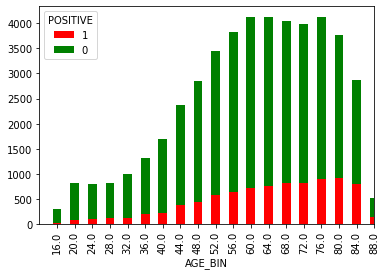

In [12]:
YEARS_FOR_BINNIG = 4
icu_stays['AGE_BIN'] = icu_stays.apply(lambda row: YEARS_FOR_BINNIG*np.floor((row['INTIME'].to_pydatetime()-row['DOB'].to_pydatetime()).days/(YEARS_FOR_BINNIG*365.25)), axis=1)
df_plot = icu_stays[['AGE_BIN','POSITIVE']]
ax=df_plot.groupby(['AGE_BIN','POSITIVE']).size().unstack()[[1, 0]].plot(kind='bar', stacked=True, color=['red', 'green'])
ax.set_xlim(-1,18)


(-1.0, 22.0)

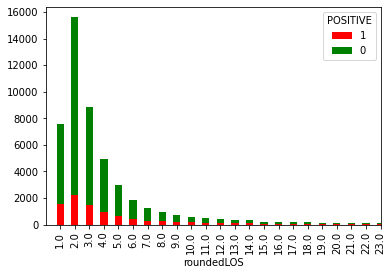

In [ ]:
icu_stays['roundedLOS'] = icu_stays.LOS.apply(np.ceil)
df_plot = icu_stays[['roundedLOS','POSITIVE']]
ax=df_plot.groupby(['roundedLOS','POSITIVE']).size().unstack()[[1, 0]].plot(kind='bar', stacked=True, color=['red', 'green'])
ax.set_xlim(-1,22)

In [13]:
icu_stays_subset = icu_stays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'OUTTIME', 'POSITIVE']].sample(frac=0.1)
icu_stays_subset.to_csv('./data/all/ICUSTAYS_LITE.csv')

In [15]:
file = 'CHARTEVENTS.csv'
chartevents = dd.read_csv(path+file,usecols=['ICUSTAY_ID','VALUENUM', 'ITEMID','CHARTTIME'], parse_dates=['CHARTTIME'],assume_missing=True).dropna() #TODO only numerics for now
chartevents['ICUSTAY_ID']=chartevents['ICUSTAY_ID'].astype('int64')
chartevents['ITEMID']=chartevents['ITEMID'].astype('int64')
filtered_chartevents = chartevents.loc[(chartevents.ICUSTAY_ID.isin(list(icu_stays_subset['ICUSTAY_ID'])))]
filtered_chartevents.compute().to_csv('./data/all/CHARTEVENTS_LITE.csv')

ValueError: ignored